## Lab 01

In [ ]:
import tensorflow as tf

import os, urllib, shutil, pathlib

We'll Use Kaggle Datasets on Cats v Dogs Cases

Our Dataset will be Train and Test

In [ ]:
origin = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/"

kaggle = "kagglecatsanddogs_5340.zip"

origin += kaggle

In [ ]:
urllib.request.urlretrieve(origin, kaggle)

('kagglecatsanddogs_5340.zip', <http.client.HTTPMessage at 0x7de5f6742a70>)

In [ ]:
shutil.unpack_archive(kaggle, '/content', 'zip')

In [ ]:
rooter = "/content/PetImages"

os.listdir(rooter)

['Dog', 'Cat']

Delete Corrupt Images on Our Dataset

In [ ]:
def imroot(root):
  i = 0
  for item in os.listdir(root):
    roti = os.path.join(root, item)
    try:
      inputi = open(roti, "rb")
      images = tf.compat.as_bytes("JFIF") in inputi.peek(10)
    finally:
      inputi.close()

    if not images:
      i += 1
      os.remove(roti)
  return i

cat_lost = imroot(os.path.join(rooter, "Cat"))

dog_lost = imroot(os.path.join(rooter, "Dog"))

cat_lost, dog_lost

(759, 831)

In [ ]:
cats = len(os.listdir(os.path.join(rooter, "Cat")))

dogs = len(os.listdir(os.path.join(rooter, "Dog")))

total_images = cats + dogs

total_images

23412

On Total, Our Images Data is 23.412 Images

Generate tf.data.Dataset From Images File in Folder

Split it to Train and Test Dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

subset = "both"; label = "binary"

image = (150, 150); split = 0.15; random = 128

unseet = 10

trainer, tester = image_dataset_from_directory(
  rooter,
  seed = unseet,
  subset = subset,
  image_size = image,
  label_mode = label,
  batch_size = random,
  validation_split = split
)

In [ ]:
labeler = trainer.class_names

labeler

['Cat', 'Dog']

Perform Image Augmentation

Using Augmentation Using SolAug Model to Perform On-The-Fly Augmentation Within a Model

Perform Caching on Train, Test Dataset to Fasten Model Training

In [ ]:
from tensorflow.keras import Model, layers

class SolAug(Model):
  def __init__(self):
    super(SolAug, self).__init__()
    self.rotation_range = layers.RandomRotation(0.2)
    self.random_zoom = layers.RandomZoom(0.2)
    self.random_flip = layers.RandomFlip()

  def call(self, inputs):
    x = self.rotation_range(inputs)
    x = self.random_zoom(x)
    y = self.random_flip(x)
    return y

Solitation = SolAug()

### Model Spirior

In [ ]:
from tensorflow.keras import models, layers

shape = (150, 150, 3)

model = models.Sequential([
  layers.Input(shape=shape),
  Solitation,
  layers.Rescaling(1.0 / 255.0),
  layers.Conv2D(16, 3,activation="relu", padding="same"),
  layers.MaxPool2D((2, 2)),
  layers.Conv2D(32, 3,activation="relu", padding="same"),
  layers.MaxPool2D((2, 2)),
  layers.Conv2D(64, 3,activation="relu", padding="same"),
  layers.MaxPool2D((2, 2)),
  layers.Conv2D(128, 3,activation="relu", padding="same"),
  layers.MaxPool2D((2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import Callback

class MonitorCallback(Callback):
  def on_epoch_end(self, epochs, logs={}):
    if logs.get("accuracy") >= 0.8 and logs.get("val_accuracy") >= 0.8:
      self.model.stop_training = True

EarlyCallback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

callbacks = [MonitorCallback(), EarlyCallback]

In [ ]:
loop = 30

hist = model.fit(trainer, epochs=loop, validation_data=tester, callbacks=callbacks)

In [ ]:
total_loop = len(hist.history["loss"])

total_loop

13

### Model Test

Testing Model on Train and Test

In [ ]:
model.evaluate(trainer, verbose=False)

[0.3894045948982239, 0.8242624998092651]

In [ ]:
model.evaluate(tester, verbose=False)

[0.39936280250549316, 0.819139838218689]

*Our Model Achieves an Impressive 0.81 Average Accuracy on Both Training and Test Datasets*

Get Helper Plot

In [ ]:
if not os.path.exists("Helplot.py"):

  giturl = "https://raw.githubusercontent.com/Kelniit/Hut/refs/heads/main/Helplot.py"

  urllib.request.urlretrieve(giturl, "Helplot.py")

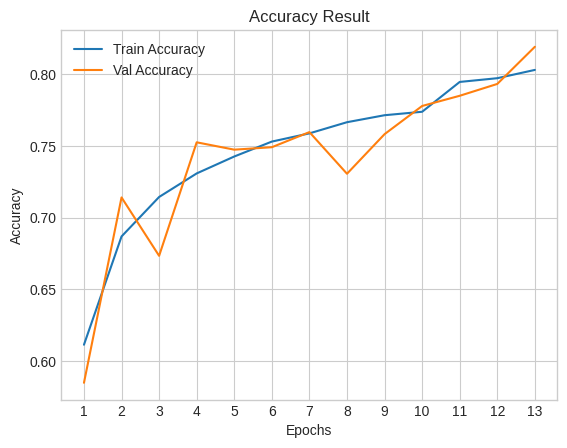

In [ ]:
from Helplot import Helplot

plot = Helplot(hist)

plot.Relplot

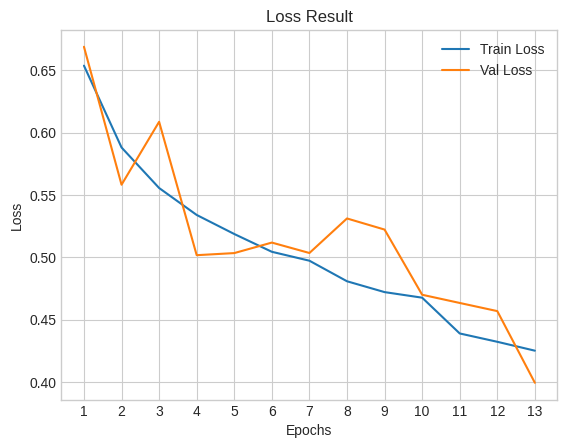

In [ ]:
plot.Falplot

In [ ]:
ModelFolder = "/content/Modelite"

model.export(ModelFolder)

#### `TensorFlow Lite`

In [ ]:
tflite = tf.lite.TFLiteConverter

tflite_model = tflite.from_saved_model(ModelFolder)

tflite_model.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = tflite_model.convert()

pathfile = "HartModel01.tflite"

tflite_model_file = pathlib.Path(pathfile)

tflite_model_file.write_bytes(tflite_model)

1456232

In [ ]:
os.path.getsize(pathfile) / float(2**20)

1.3887710571289062

#### `Test TensorFlow Lite Model`

In [ ]:
interpreter = tf.lite.Interpreter(model_path=pathfile)

interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor'], 'outputs': ['output_0']}}

In [ ]:
lite_interpreter = interpreter.get_signature_runner('serving_default')

lite_interpreter

In [ ]:
dogs = os.listdir(os.path.join(rooter, "Dog"))[0]

dogs = os.path.join(rooter, "Dog", dogs)

sample = tf.keras.utils.load_img(dogs, target_size=(150, 150))

sample = tf.keras.utils.img_to_array(sample)

sample = tf.expand_dims(sample, axis=0)

sample = tf.cast(sample / 255.0, tf.float32)

sample.shape

TensorShape([1, 150, 150, 3])

In [ ]:
testa = lite_interpreter(keras_tensor=sample)['output_0']

testa

array([[0.0746466]], dtype=float32)

In [ ]:
test_img, test_label = next(iter(tester))

logits = model.predict(test_img, verbose=0)

logits.shape

(128, 1)

#### `TensorFlow Serving`

In [ ]:
class Outlabel(tf.keras.layers.Layer):
  def __init__(self):
    super(Outlabel, self).__init__()
    self.label = labeler

  def call(self, inputs):
    tf.config.run_functions_eagerly(True)
    logits = tf.cast(tf.round(inputs), tf.int32)
    logits = tf.gather(self.label, logits)
    return logits

In [ ]:
input_layer = tf.keras.layers.Input(shape=(150, 150, 3))

modular = model(input_layer)

output_layer = Outlabel()(modular)

modular_server = tf.keras.Model(input_layer, output_layer)

modular_server.output

<KerasTensor shape=(None, 1), dtype=string, sparse=False, name=keras_tensor_17>

In [ ]:
import warnings

warnings.filterwarnings("ignore")

tester = modular_server.predict(test_img, verbose=False)

tester[:3]

array([[b'Dog'],
       [b'Cat'],
       [b'Cat']], dtype=object)

In [ ]:
ModelFolder = "/content/ModelServer"

ModelSerial = "1"

ModuleFolder = os.path.join(ModelFolder, ModelSerial)

modular_server.export(ModuleFolder)

In [ ]:
!apt update

!apt-get install tensorflow-model-server

In [ ]:
os.environ["ModelFolder"] = ModelFolder

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=inter_model \
  --model_base_path="${ModelFolder}" > server.log 2>&1

In [ ]:
!tail server.log

In [ ]:
import json, requests

test_images = test_img.numpy().tolist()

url = "http://127.0.0.1:8501/v1/models/inter_model:predict"

image = json.dumps({"signature_name":"serving_default", "instances":test_images})

content = {"content-type":"application/json"}

response = requests.post(url, data=image, headers=content)

loader = json.loads(response.text)

result = loader["predictions"]

result[:5]

[['Cat'], ['Cat'], ['Cat'], ['Cat'], ['Dog']]